In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# from bin import load_bgi as ld

In [18]:
# adata = ld.load_bin('./gRNA/B926/cut.combined.D03658A6.merged.sgRNA.gem', bin_size=1, library_id='spatial')

: 

: 

: 

In [2]:
adata = sc.read_h5ad("./tmp.h5")

In [6]:
np.save('coord.npy', adata.obsm['spatial'])

In [14]:
labels = np.load('labels.npy')
coords = adata.obsm['spatial'].astype(int)
adata.obs['label'] = [labels[tuple(coord)] for coord in coords]

In [15]:
adata.obs['label']

65225573      9521.0
57275652         0.0
46706710     10115.0
39541766      5330.0
245930303        0.0
              ...   
74642357     15823.0
150634349        0.0
254500270    24120.0
235457983        0.0
22209809         0.0
Name: label, Length: 10159113, dtype: float64

In [1]:
adata.obsm['spatial']

NameError: name 'adata' is not defined

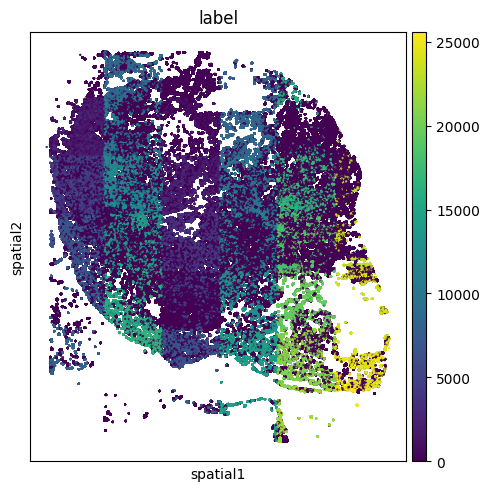

In [16]:
sq.pl.spatial_scatter(adata, color='label', size=1, shape=None, library_id='spatial')

In [4]:
import pickle
with open('sum_expr.pkl', 'rb') as f:
    sum_expr = pickle.load(f)

In [5]:
with open('coord_groups.pkl', 'rb') as f:
    coord_groups = pickle.load(f)

In [6]:
import anndata as ad

In [7]:
x = np.array(list(sum_expr.values()))

In [8]:
x = x[:, 0, :]

In [9]:
new_data = ad.AnnData(X=x, obs=pd.DataFrame(index=sum_expr.keys()), var=adata.var)

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [10]:
new_data.obsm['spatial'] = np.array(list(coord_groups.values()))

In [12]:
new_data.X.sum()

24673284

In [ ]:
new_data.write_h5ad('./RNA/D03658A6.segment.gem')

In [ ]:
new_data = sc.read_h5ad('./RNA/D03658A6.segment.gem')

In [13]:
from bin import utils

In [14]:
new_data = utils.remove_mito_ribo_hk_lnc_genes(new_data)

In [ ]:
del new_data.var

In [15]:
adata = new_data.copy()
adata.layers['counts'] = adata.X.copy()

In [16]:
sc.pp.calculate_qc_metrics(adata, log1p=False, inplace=True)

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_qc.py:422: RuntimeWarning: invalid value encountered in divide
  return values / sums[:, None]


In [ ]:
adata

AnnData object with n_obs × n_vars = 58275 × 16987
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'spatial'
    layers: 'counts'

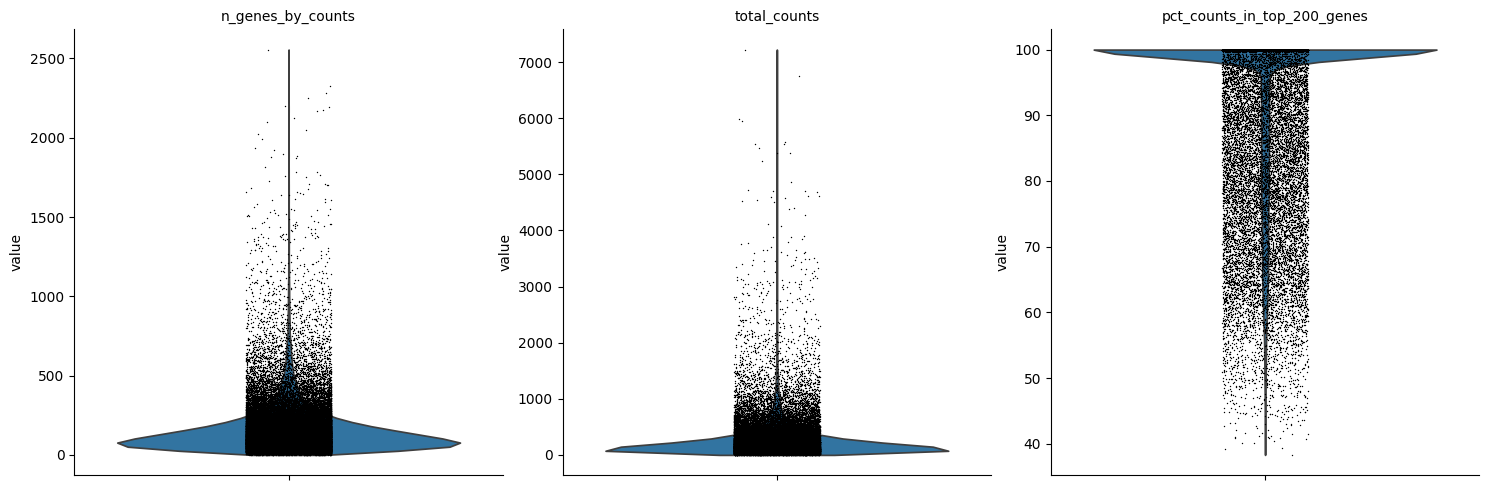

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_in_top_200_genes'], multi_panel=True)

In [17]:
sc.pp.filter_cells(adata, min_counts=200)
sc.pp.filter_cells(adata, min_genes=3)
sc.pp.filter_genes(adata, min_cells=3)

In [18]:
sc.pp.filter_cells(adata, max_counts=1200)

In [19]:
adata.X = adata.layers['counts'].copy()

In [20]:
gdata = adata[:, adata.var_names.str.startswith('sg')].copy()

In [21]:
fdata = adata[:, ~adata.var_names.str.startswith('sg')].copy()

In [22]:
sc.pp.normalize_total(fdata)
sc.pp.log1p(fdata)

In [ ]:
fdata

AnnData object with n_obs × n_vars = 22246 × 12874
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p'
    obsm: 'spatial'
    layers: 'counts'

In [25]:
def combine_guide_replicates(gdata):
    sgs = gdata.var_names.str.split('_', n=1).str[0]
    sgs_grouped = pd.DataFrame(gdata.X, columns=gdata.var_names)
    sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()

    cgdata = ad.AnnData(sgs_grouped, obs=gdata.obs, var=pd.DataFrame(index=sgs_grouped.columns))
    cgdata.obsm['spatial'] = gdata.obsm['spatial']
    return cgdata
gdata = combine_guide_replicates(gdata)

In [30]:
map_dict = pd.DataFrame(gdata.var_names).to_dict()[0]
perturb = pd.DataFrame(gdata.X.argmax(axis=1))[0].map(map_dict)
fdata.obs["perturb_gene"] = perturb
fdata.obs["perturb_gene"][gdata.X.max(axis=1) == 0] = 'None'

/tmp/ipykernel_19446/4152048278.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdata.obs["perturb_gene"][gdata.X.max(axis=1) == 0] = 'None'


In [32]:
fdata.obs.perturb_gene

10003.0    None
11435.0    None
10537.0     NaN
60223.0     NaN
60908.0     NaN
           ... 
59861.0    None
56653.0    None
50315.0    None
29037.0    None
12652.0    None
Name: perturb_gene, Length: 22246, dtype: object

: 

In [ ]:
sc.pp.pca(fdata)

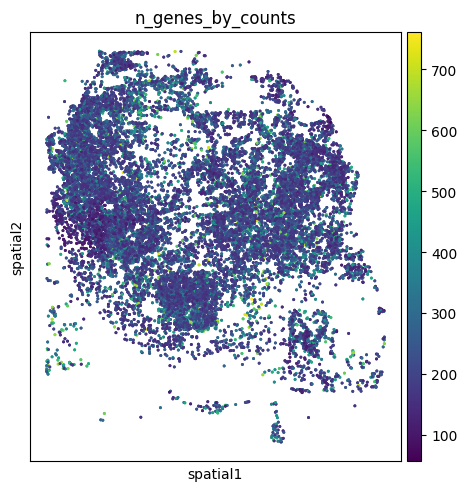

In [ ]:
sq.pl.spatial_scatter(fdata, color='n_genes_by_counts', shape=None, size=5, library_id='spatial')

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


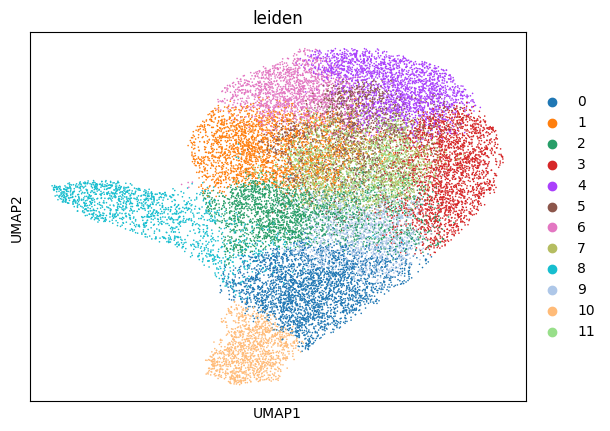

In [ ]:
sc.pp.neighbors(fdata, n_pcs=5, n_neighbors=10)
sc.tl.umap(fdata)
sc.tl.leiden(fdata, resolution=0.5)
sc.pl.umap(fdata, color='leiden')

In [ ]:
sc.tl.rank_genes_groups(fdata, groupby='leiden', method='t-test')

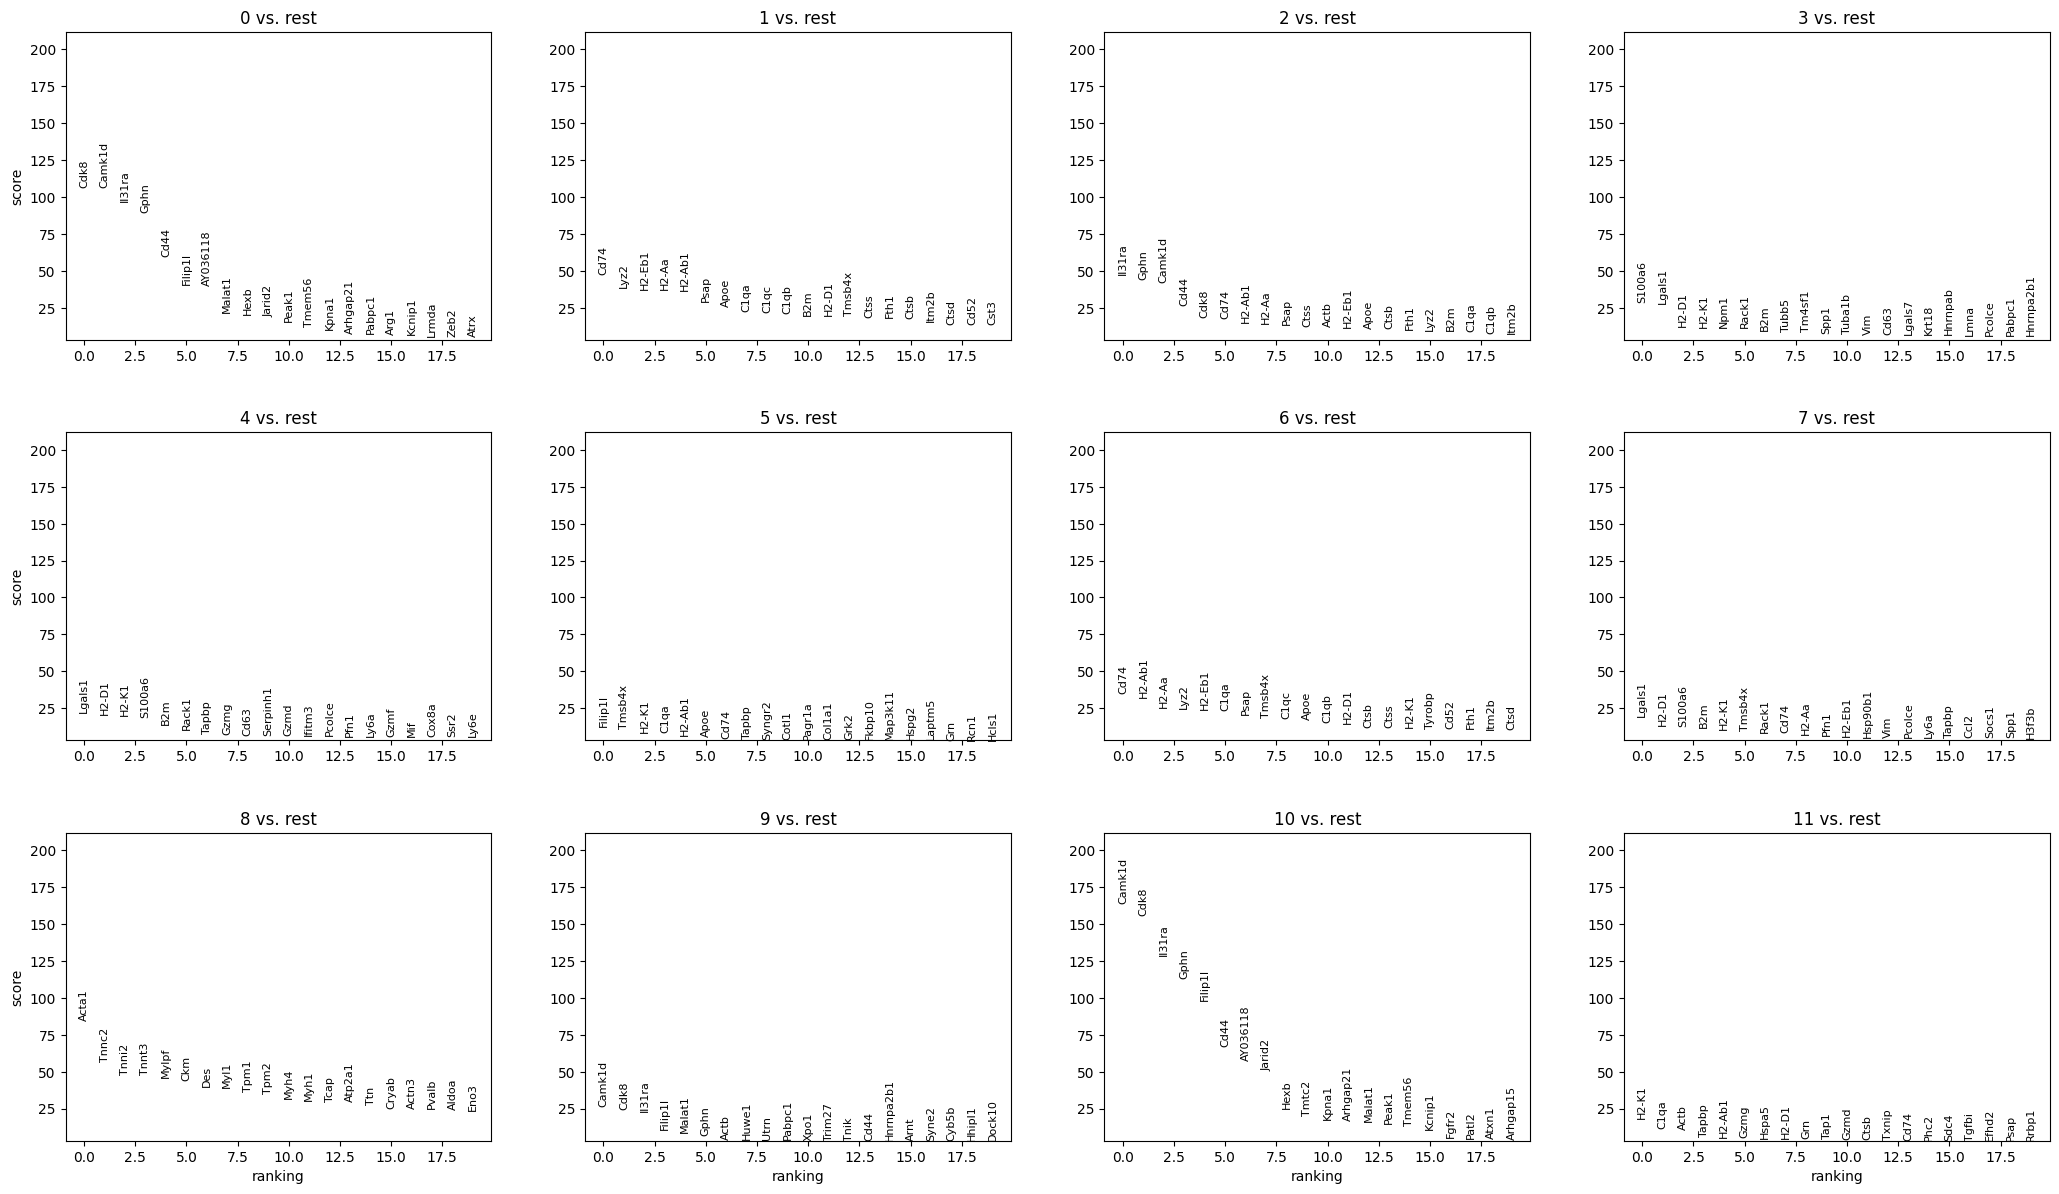

In [ ]:
sc.pl.rank_genes_groups(fdata, n_genes=20)

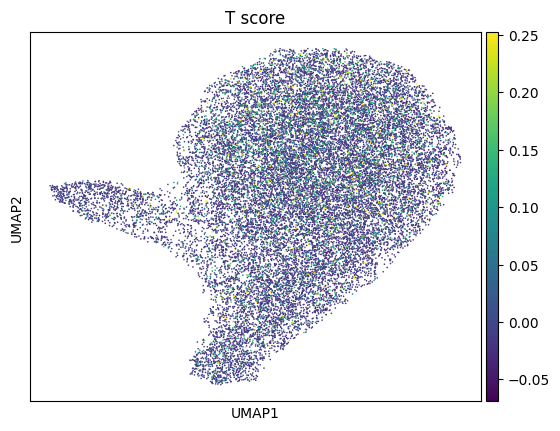

In [ ]:
sc.tl.score_genes(fdata, gene_list=['Cd8a', 'Cd8b1', 'Cd3d', 'Cd3e', 'Cd3g'], score_name='T score')
sc.pl.umap(fdata, color='T score', vmax='p99')

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


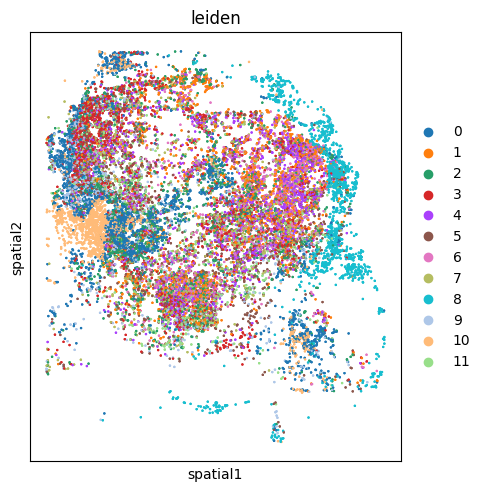

In [ ]:
sq.pl.spatial_scatter(fdata, color='leiden', shape=None, size=2, library_id='spatial')